In [3]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [4]:
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')

models = [
    'spectrum',
    'sdne_20_1_1', 'sdne_30_1_1', 'sdne_40_1_1', 'sdne_50_1_1', 'sdne_100_1_1', 'sdne_100_5_5', 'sdne_100_10_10', 'sdne_100_15_15', 'sdne_100_20_20',
]

## Simulation 1

### Dataset

For each covariance in a list of different covariances between graph pairs, we simulate 30 times (n_simulations) a list of 50 (n_graphs) pairs of graphs from the erdos-renyi family of graphs. For each pair of graph, we sample a random variable p from a multivariate gaussian distribution with fixed mean and covariance.

### Model

1) $\textbf{Spectrum}$: For each pair of graphs, compute the spectral radii for each adjacency matrix individually, and compute the Spearman's rank correlation between the spectral radiis for each graph.

2) $\textbf{SDNE}$: For each epoch, for each pair of graphs, compute the embeddings using the SDNE (autoencoder), and compute the Spearman's rank correlation between the vectorial version of the embeddings of each graph.


In [5]:
dataset = 'simulation1'

prediction_error = []
for model in models:

    # load data
    data = load_pickle(os.path.join(outputs_path, dataset, model, 'results.pkl'))

    try:
        pred_df = pd.DataFrame({"pred": data['pred'], "true": data["true"]}).dropna()
    except:
        pred_df = pd.DataFrame({"pred": data['test_pred'], "true": data["test_true"]}).dropna()

    # compute relevant metrics
    mse = mean_squared_error(pred_df['true'], pred_df['pred'])
    mae = mean_absolute_error(pred_df['true'], pred_df['pred'])

    # store results
    prediction_error.append({"model": model, "dataset": dataset, "mse": mse, "mae": mae})

prediction_error_df = pd.DataFrame(prediction_error)

## MSE Comparison

In [6]:
prediction_error_df.sort_values(by=['mse'], ascending=True)

,model,dataset,mse,mae
6,sdne_100_5_5,simulation1,0.332558,0.499975
5,sdne_100_1_1,simulation1,0.333050,0.500010
3,sdne_40_1_1,simulation1,0.333067,0.500005
4,sdne_50_1_1,simulation1,0.333495,0.499982
2,sdne_30_1_1,simulation1,0.333648,0.499996
8,sdne_100_15_15,simulation1,0.334392,0.500206
7,sdne_100_10_10,simulation1,0.347191,0.507014
9,sdne_100_20_20,simulation1,0.362240,0.514483
1,sdne_20_1_1,simulation1,0.490338,0.578652
0,spectrum,simulation1,1.434986,1.049994


In [7]:
prediction_error_df.sort_values(by=['mse'], ascending=True)

,model,dataset,mse,mae
6,sdne_100_5_5,simulation1,0.332558,0.499975
5,sdne_100_1_1,simulation1,0.333050,0.500010
3,sdne_40_1_1,simulation1,0.333067,0.500005
4,sdne_50_1_1,simulation1,0.333495,0.499982
2,sdne_30_1_1,simulation1,0.333648,0.499996
8,sdne_100_15_15,simulation1,0.334392,0.500206
7,sdne_100_10_10,simulation1,0.347191,0.507014
9,sdne_100_20_20,simulation1,0.362240,0.514483
1,sdne_20_1_1,simulation1,0.490338,0.578652
0,spectrum,simulation1,1.434986,1.049994


## Simulation 1a

### Dataset

For each covariance in a list of different covariances between graph pairs, for n in a list of the number of nodes (10 to 100, 10 by 10), we simulate 30 times (n_simulations) a list of 50 (n_graphs) pairs of graphs from the erdos-renyi family of graphs. For each pair of graph, we sample a random variable p from a multivariate gaussian distribution with fixed mean and covariance.

In [8]:
models_ovrd = ["spectrum"]

prediction_error_e1a = []
dataset = 'simulation1a'
for model in models_ovrd:

    # list dirs path
    n_nodes = os.listdir(os.path.join(outputs_path, dataset))
    for n in n_nodes:

        # load data
        data = load_pickle(os.path.join(outputs_path, dataset, n, model, 'results.pkl'))


        try:
            pred_df = pd.DataFrame({"pred": data['pred'], "true": data["true"]}).dropna()
        except:
            pred_df = pd.DataFrame({"pred": data['test_pred'], "true": data["test_true"]}).dropna()

        # compute relevant metrics
        mse = mean_squared_error(pred_df['true'], pred_df['pred'])
        mae = mean_absolute_error(pred_df['true'], pred_df['pred'])

        # store results
        prediction_error_e1a.append({"model": model, "dataset": dataset, "n_nodes": n, "mse": mse, "mae": mae})
prediction_error_e1a_df = pd.DataFrame(prediction_error_e1a)

## MSE as a function of the number of nodes

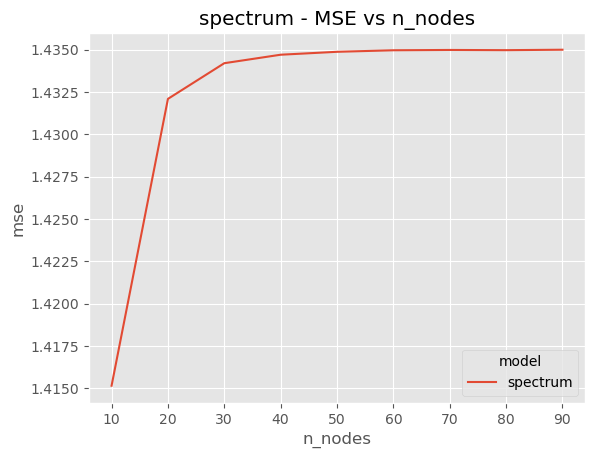

In [15]:
prediction_error_e1a_df

for model in models_ovrd:

    tmp_prediction_df = prediction_error_e1a_df[prediction_error_e1a_df['model'] == model]
    tmp_prediction_df = tmp_prediction_df.sort_values(by=['n_nodes'], ascending=True)
    # line plot of the mse column as a function of the number of nodes
    plt.title(f'{model} - MSE vs n_nodes')
    sns.lineplot(x="n_nodes", y="mse", data=tmp_prediction_df, hue="model")